# `NMF visualization`

Modified from the pyLDAvis scikit-learn example notebook.

In [1]:
import re, io, os
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict, OrderedDict
import urllib.request
import random
random.seed(13)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, PCA, TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

import umap

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline

import seaborn as sns

plt.style.use('seaborn')
matplotlib.style.use('seaborn')
plt.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'font.size': 20})

## Helper Functions

In [3]:
def tokenize(data):
    index = defaultdict(str)
    
    with urllib.request.urlopen(data) as file:
        for line in file.read().decode('latin-1').splitlines():
            # pull out takahashi lines
            m = re.match(r'^<(f.*?)\..*;H> +(\S.*)$', line)
            if not m:
                continue

            transcription = m.group(2)
            pg = str(m.group(1))

            # ignore entire line if it has a {&NNN} or {&.} code
            if re.search(r'\{&(\d|\.)+\}', transcription):
                continue

            # remove extraneous chracters ! and %
            s = transcription.replace("!", "").replace("%", "")
            
            # delete all end of line {comments} (between one and three observed)
            # ...with optional line terminator
            # allow 0 occurences to remove end-of-line markers (- or =)
            s = re.sub(r'([-=]?\{[^\{\}]+?\}){0,3}[-=]?\s*$', "", s)

            # delete start of line {comments} (single or double)
            s = re.sub(r'^(\{[^\{\}]+?\}){1,2}', "", s)

            # simplification: tags preceeded by -= are word breaks
            s = re.sub(r'[-=]\{[^\{\}]+?\}', '.', s)

            # these tags are nulls
            # plant is a null in one case where it is just {plant}
            # otherwise (above) it is a word break
            # s = re.sub(r'\{(fold|crease|blot|&\w.?|plant)\}', "", s)
            # simplification: remaining tags in curly brackets
            s = re.sub(r'\{[^\{\}]+?\}', '', s)

            # special case .{\} is still a word break
            s = re.sub(r'\.\{\\\}', ".", s)

            # split on word boundaries
            # exclude null words ('')
            words = [str(w) for w in s.split(".") if w]
            paragraph = ' '.join(words).lstrip()
            
            index[pg] += (paragraph)

    return index


In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [5]:
def output_top(n=20, embedding="nmf"):
    embedding = str.lower(embedding)
    top_idx = []
    outfile = ""
    if embedding == "nmf":
        top_idx = np.argsort(nmf_embedding, axis=0)[-n:]
        outfile = open('./out/nmf_'+str(num_topics)+'_topics_top_'+str(n)+'.txt', 'w') 
    elif embedding == "lsa":
        top_idx = np.argsort(lsa_embedding, axis=0)[-n:]
        outfile = open('./out/lsa_'+str(num_topics)+'_topics_top_'+str(n)+'.txt', 'w') 
    else:
        print("Bad embedding")
        return -1
    count = 0
    for idxs in top_idx.T: 
        print("\nTopic {}:".format(count))
        print("\nTopic {}:".format(count), file=outfile)
        for idx in np.flip(idxs): # they're in reverse order
            folio = vms_mapping[idx]
            # print twice to get both file output and stdout in the notebook
            print("("+str(vms[folio].nmf_topic)+") "+folio+": hand "+str(vms[folio].hand)+", language "+vms[folio].lang+", "+vms[folio].topic)
            print("("+str(vms[folio].nmf_topic)+") "+folio+": hand "+str(vms[folio].hand)+", language "+vms[folio].lang+", "+vms[folio].topic, file=outfile)
        count += 1
    outfile.close()
    

## Load Voynich Data

Load the Pickle files produced by vms_vectorize.py

In [6]:
models_path = "./models"

# load in the pickle files of stored models
with open("{}/tfidf_vectorizer.pk".format(models_path), "rb") as f:
    tfidf_vectorizer = pickle.load(f)
with open("{}/vms_tf.pk".format(models_path), "rb") as f:
    vms_tf = pickle.load(f)
with open("{}/vms_mapping.pk".format(models_path), "rb") as f:
    vms_mapping = pickle.load(f)
with open("{}/tf_vectorizer.pk".format(models_path), "rb") as f:
    tf_vectorizer = pickle.load(f)
with open("{}/vms_tfidf.pk".format(models_path), "rb") as f:
    vms_tfidf = pickle.load(f)

index = tokenize("https://raw.githubusercontent.com/rachelbari/voynich-topic-modeling/master/data/text16e6.evt")
documents = [index[key] for key in index.keys()]


/home/annie/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/annie/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/annie/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


#### Make a dict containing information about each page of the VMS

In [7]:
# a class for a single folio
# currently just contains state variables
# will eventually have a show() method to display the page
class Folio:
    def __init__(self, name, quire, topic="?", hand=0, lang="?"):
        self.name = name
        self.quire = int(quire)
        self.topic = topic
        self.hand = int(hand)
        self.lang = lang
        self.topic_color = "C1"
        self.lang_color = "C0"

In [8]:
lfd_map = pd.read_csv("./lfd_map.csv")
print(lfd_map)
vms = OrderedDict()
topic_dict = {}
lang_dict = {}
topic_color = []
lang_color = []
for row in lfd_map.iterrows():
    # declare the folio object
    folio = Folio(row[1].folio, row[1].quire, row[1].topic, row[1].hand, row[1].language)
    
    # set up the topic color
    if not row[1].topic in topic_dict.keys():
        topic_dict[row[1].topic] = "C"+str(len(topic_dict))
    folio.topic_color = topic_dict[folio.topic]
    topic_color.append(folio.topic_color)    
    print(topic_dict[folio.topic])
    
    # set up the language color
    if not row[1].language in lang_dict.keys():
        lang_dict[row[1].language] = "C"+str(len(lang_dict))
    folio.lang_color = lang_dict[folio.lang]
    lang_color.append(folio.lang_color)    
    print(lang_dict[folio.lang])
    
    vms[folio.name] = folio

vms_df = lfd_map.assign(topic_color = topic_color)
vms_df = vms_df.assign(lang_color = lang_color)

print(vms_df)
print(type(lfd_map))
print(list(vms.items())[0][1].topic_color)
#print(vms['f1v'])


     folio               topic  hand language  quire
0      f1r           botanical     1        a      1
1      f1v           botanical     1        a      1
2      f2r           botanical     1        a      1
3      f2v           botanical     1        a      1
4      f3r           botanical     1        a      1
..     ...                 ...   ...      ...    ...
220  f114r  starred paragraphs     3        b     18
221  f114v  starred paragraphs     3        b     18
222  f115r  starred paragraphs     3        b     18
223  f115v  starred paragraphs     3        b     18
224  f116r  starred paragraphs     3        b     18

[225 rows x 5 columns]
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C1
C0
C1
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C0
C

## Fit NMF models

In [9]:
num_topics = 4

# reset the topic labels
for key in vms.keys():
    vms[key].nmf_topic = 0

nmf_tfidf = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf_tfidf.fit(vms_tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_tfidf, tfidf_feature_names, 10)

nmf_embedding = nmf_tfidf.transform(vms_tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

# assign each page to its nearest topic, and log that in the vms dict
i = 0
topic_col = []
for topic in nmf_embedding.argmax(axis=1):
    name = lfd_map['folio'].values[i]
    vms[name].nmf_topic = topic
    topic_col.append(topic)
    i += 1
vms_df = vms_df.assign(topic_nmf = topic_col)

vms_df.to_csv("./out/nmf_"+str(num_topics)+"_map.csv")


Topic #0:
shedy chedy qokeedy qokain qokedy ol qokeey qol qokal shey

Topic #1:
daiin chol chor chy shol cthy sho shor dain cthor

Topic #2:
aiin ar al or okaiin okar chdy otaiin chedy qokaiin

Topic #3:
okeol cheol ol qokeol or cheor daiin chol okeey ckhey



### Also fit LSA models (with SVD)

In [10]:
# reset the topic labels
for key in vms.keys():
    vms[key].lsa_topic = 0

lsa_tfidf = TruncatedSVD(n_components=num_topics)
lsa_tfidf.fit(vms_tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lsa_tfidf, tfidf_feature_names, 10)

lsa_embedding = lsa_tfidf.transform(vms_tfidf)
lsa_embedding = (lsa_embedding - lsa_embedding.mean(axis=0))/lsa_embedding.std(axis=0)

# assign each page to its nearest topic, and log that in the vms dict
i = 0
topic_col = []
for topic in lsa_embedding.argmax(axis=1):
    name = lfd_map['folio'].values[i]
    vms[name].lsa_topic = topic
    topic_col.append(topic)
    i += 1
vms_df = vms_df.assign(topic_lsa = topic_col)

vms_df.to_csv("./out/lsa_"+str(num_topics)+"_map.csv")


Topic #0:
chedy daiin shedy ol aiin chol or ar qokeedy qokedy

Topic #1:
daiin chol chor cthy chy shol sho cthol cthor shor

Topic #2:
aiin ar al or okar air otaiin oteos oteey okaiin

Topic #3:
okeol cheol qokeey qokeol okeey cheor cheey sheol shey ckhey



## Making sense of the data

Using techniques from https://www.kaggle.com/xdsarkar/nips-papers-visualized-with-nmf-and-t-sne

First, we transform the tfidf-matrix into an nmf-embedding, and look at which folios are most closely associated with each topic

In [11]:
output_top(n=10, embedding="lsa")


Topic 0:
(0) f76r: hand 2, language b, balneological
(0) f103v: hand 3, language b, starred paragraphs
(0) f75r: hand 2, language b, balneological
(0) f79v: hand 2, language b, balneological
(0) f79r: hand 2, language b, balneological
(0) f84r: hand 2, language b, balneological
(0) f103r: hand 3, language b, starred paragraphs
(2) f107v: hand 3, language b, starred paragraphs
(0) f76v: hand 2, language b, balneological
(0) f78v: hand 2, language b, balneological

Topic 1:
(1) f15v: hand 1, language a, botanical
(1) f47r: hand 1, language a, botanical
(1) f42r: hand 1, language a, botanical
(1) f49v: hand 1, language a, botanical
(1) f10r: hand 1, language a, botanical
(1) f32v: hand 1, language a, botanical
(1) f20v: hand 1, language a, botanical
(1) f9v: hand 1, language a, botanical
(1) f19r: hand 1, language a, botanical
(1) f4r: hand 1, language a, botanical

Topic 2:
(2) f105v: hand 3, language b, starred paragraphs
(2) f72r1: hand 4, language b, astrology
(2) f113v: hand 3, lang

In [12]:
output_top(n=10, embedding="nmf")


Topic 0:
(0) f75r: hand 2, language b, balneological
(0) f77v: hand 2, language b, balneological
(0) f82v: hand 2, language b, balneological
(0) f77r: hand 2, language b, balneological
(0) f84r: hand 2, language b, balneological
(0) f83v: hand 2, language b, balneological
(0) f76v: hand 2, language b, balneological
(0) f76r: hand 2, language b, balneological
(0) f75v: hand 2, language b, balneological
(0) f103r: hand 3, language b, starred paragraphs

Topic 1:
(1) f47r: hand 1, language a, botanical
(1) f15v: hand 1, language a, botanical
(1) f10r: hand 1, language a, botanical
(1) f42r: hand 1, language a, botanical
(1) f32v: hand 1, language a, botanical
(1) f49v: hand 1, language a, botanical
(1) f4r: hand 1, language a, botanical
(1) f9v: hand 1, language a, botanical
(1) f20v: hand 1, language a, botanical
(1) f19r: hand 1, language a, botanical

Topic 2:
(2) f113v: hand 3, language b, starred paragraphs
(2) f86v5: hand 2, language b, rose
(2) f105v: hand 3, language b, starred p

## Visualize the results with various dimension reduction methods

In [13]:
# get the colors to put in the legend
topic_legend, topics = [], []
lang_legend, langs = [], []
color_sequence=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'] # please don't use more than 10 topics
cluster_legend, clusters = [], []

plt.style.use('seaborn')
matplotlib.style.use('seaborn')
plt.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'font.size': 20})
for i in range(len(topic_dict)): 
    topic_legend.append(mpatches.Ellipse((0,0), 1, 1, fc=list(topic_dict.values())[i]))
    topics.append(list(topic_dict.keys())[i])
for i in range(len(lang_dict)): 
    lang_legend.append(mpatches.Ellipse((0,0), 1, 1, fc=list(lang_dict.values())[i]))
    langs.append(list(lang_dict.keys())[i])
for i in range(num_topics):
    cluster_legend.append(mpatches.Ellipse((0,0), 1, 1, fc=color_sequence[i]))
    clusters.append("Topic "+str(i))


In [22]:
# general visualization method
def visualize(embedding, color_code, method, vec_type="NMF", show=True, perplexity=15, decay=5, knn=4, n_neighbors=20, min_dist=0.1, random_state=17):
    method = str.lower(method)
    transformer = []
    dim_reduced = []
    
    if (method == "tsne" or method == "t-sne"):
        print("using tSNE")
        tsne = TSNE(perplexity=perplexity, random_state=random_state, n_iter=50000)
        dim_reduced = tsne.fit_transform(embedding)
    elif method == "umap":
        print("using UMAP")
        UMAP = umap.UMAP(n_neighbors=n_neighbors, random_state=random_state, min_dist=min_dist, n_components=2)
        dim_reduced = UMAP.fit_transform(embedding)
    elif method == "pca":
        print("using PCA")
        pca = PCA(n_components=2)
        dim_reduced = pca.fit_transform(embedding)
    else:
        print("Error: unknown dimension reduction method")
        return -1
        
    x_axis=dim_reduced[:,0]
    y_axis=dim_reduced[:,1]


    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.axis('off')
    plt.title("VMS clustering: "+str(num_topics)+"-topic "+vec_type+", visualized with "+method, fontsize=20)
    
    if color_code == 'topic':
        ax.scatter(x=x_axis, y=y_axis, s=16, c=vms_df.topic_color)
        ax.legend(topic_legend, topics, fontsize=20)#, loc=(0.1, 0.72))
    elif color_code == 'lang':
        ax.scatter(x=x_axis, y=y_axis, s=16, c=vms_df.lang_color)
        ax.legend(lang_legend, langs, fontsize=20)#, loc=(0.1, 0.72))
    elif color_code == 'cluster':
        cluster_color = []
        if str.lower(vec_type) == "nmf":
            for row in vms_df.iterrows():
                cluster_color.append("C"+str(row[1]['topic_nmf']))
        elif str.lower(vec_type) == 'lsa':
            for row in vms_df.iterrows():
                cluster_color.append("C"+str(row[1]['topic_lsa']))
        ax.scatter(x=x_axis, y=y_axis, s=16, c=cluster_color)
        ax.legend(cluster_legend, clusters, fontsize=20)#, loc=(0.1, 0.72))
                

    plt.tight_layout()
    plt.savefig("./out/"+vec_type+"_"+str(num_topics)+"clusters_"+method+"_"+color_code+"s.png")
    if show: plt.show()
    else: plt.close()
    

## Visualize things!
The visualize method supports t-SNE, UMAP, PCA, and PHATE

#### t-SNE
t-SNE is one of the standard dimension reduction methods, and is good overall, but is highly dependent on the settings of its hyperparameters.
t-SNE generally does well with this data set, using perplexity of 15-25. 
It produces several distinct topic clusters, including one primerily balneological cluster and one primerily recipies cluster. 
The languages are well-separated, but appear to be part of one continuous distribution, rather than independent clusters.

#### UMAP
UMAP is a newer dimension reduction methods that makes some assumptions about the data - namely that it is made of a collection of locally connected manifolds, ie, that it is a collection of well-formed clusters.
UMAP performs similarly to t-SNE on this data. 
It produces the same recipie and balneological clusters as t-SNE, and splits the language B botanical topic into a mostly separate cluster.

#### PCA
Principal Component Analysis is the oldest dimension reduction method.
It does very, very poorly on this data.
It manages to put language A on one side of the plot and language B on the other, but does not produce any of the distinct topic clusters that other methods produce


In [50]:
# Generate ALL the graphs, dumped into ./out/
# This is also a good reference for all the visualize() options

# possible sources for point colors
color_codes = ['lang', 'topic', 'cluster']
# lang: currier language (A, B, or unknown)
# topic: human-determined page topic (from LFD's Excel sheet)
# cluster: topic number as determined by clustering algorithm

# dimension reduction methods
methods = ['tSNE', 'UMAP', 'PCA'] # case insensitive
# tSNE: t-distributed Stochastic Neighbor Embedding (modern, generally good)
# UMAP: Uniform Manifold Approximation and Projection (new, fancy)
# PCA: Principal Component Analysis (old, well-understood, works poorly on this data)

for method in methods:
    for color_code in color_codes:
        visualize(nmf_embedding, color_code=color_code, method=method, vec_type="NMF", show=False)
        visualize(lsa_embedding, color_code=color_code, method=method, vec_type="LSA", show=False)

        

using tSNE


NameError: name 'mpl' is not defined

In [16]:
#visualize(nmf_embedding, color_code='cluster', method='tsne', perplexity = 15)
#visualize(nmf_embedding, color_code = 'topic', method='umap', n_neighbors=20)
#visualize(nmf_embedding, color_code='cluster', method='pca')

using tSNE


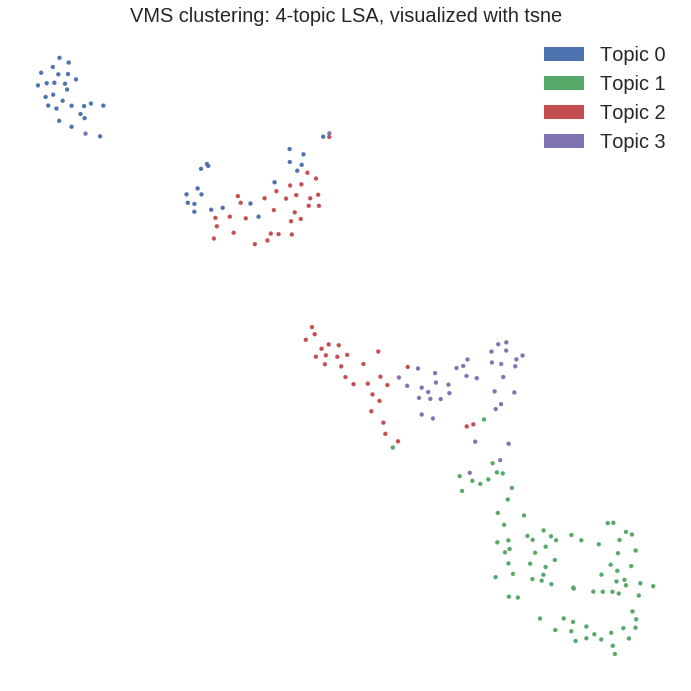

In [23]:
visualize(lsa_embedding, color_code='cluster', method='tsne', perplexity = 20, vec_type="LSA")
#visualize(lsa_embedding, color_code = 'topic', method='umap', n_neighbors=15, vec_type="LSA")
#visualize(lsa_embedding, color_code='topic', method='pca', vec_type="LSA")

### Histograms

        time kind  data
0 2011-01-04    y     4
1 2011-01-05    y     9
2 2011-01-06    y     2
3 2011-01-04    z     1
4 2011-01-05    z     2
5 2011-01-06    z     3
6 2011-01-04    k    11
7 2011-01-05    k    12
8 2011-01-06    k    13


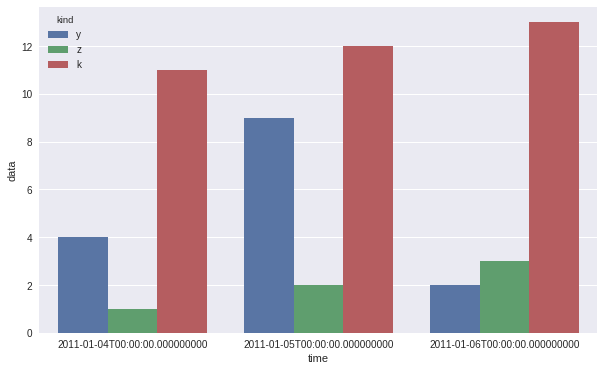

In [24]:
# First, we're going to need some new dataframes

import datetime

x = [
    datetime.datetime(2011, 1, 4, 0, 0),
    datetime.datetime(2011, 1, 5, 0, 0),
    datetime.datetime(2011, 1, 6, 0, 0)
]
y = [4, 9, 2]
z = [1, 2, 3]
k = [11, 12, 13]

df = pd.DataFrame(zip(x*3, ["y"]*3+["z"]*3+["k"]*3, y+z+k), columns=["time", "kind", "data"])
print(df)
plt.figure(figsize=(10, 6))
sns.barplot(x="time", hue="kind", y="data", data=df)
plt.show()

[0, 1, 2, 3]
['b', 'a']
topic_nmf and language in the VMS


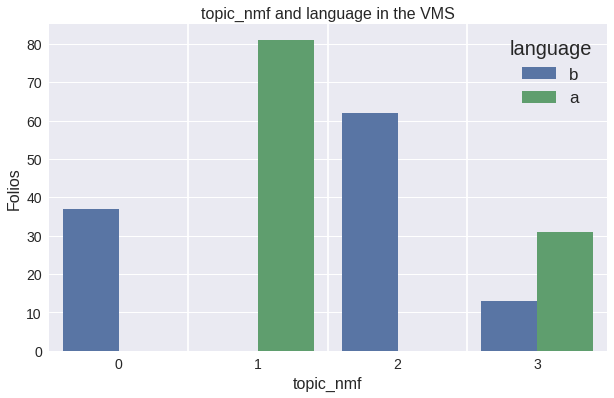

[0, 1, 2, 3]
['recipies', 'unknown', 'balneological', 'botanical', 'rose', 'starred paragraphs', 'astrology']
topic_nmf and topic in the VMS


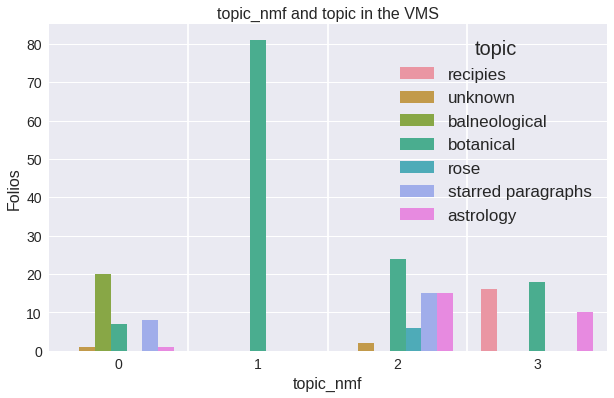

[0, 1, 2, 3]
[1, 2, 3, 4]
topic_nmf and hand in the VMS


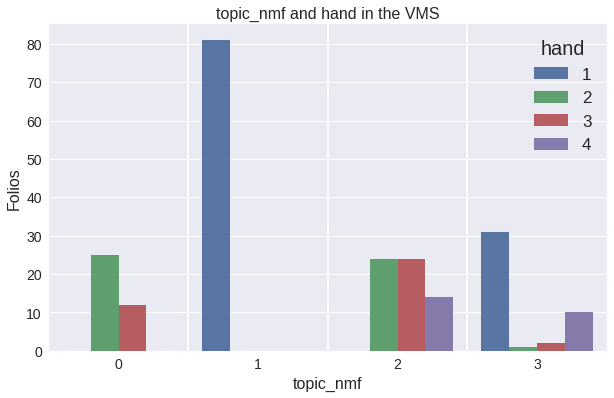

['recipies', 'unknown', 'balneological', 'botanical', 'rose', 'starred paragraphs', 'astrology']
['b', 'a']
topic and language in the VMS


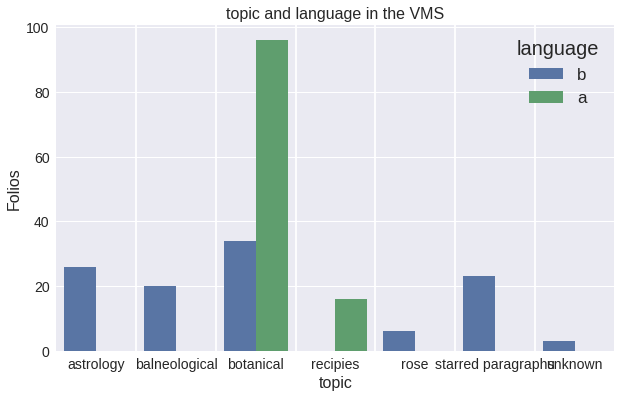

['b', 'a']
['recipies', 'unknown', 'balneological', 'botanical', 'rose', 'starred paragraphs', 'astrology']
language and topic in the VMS


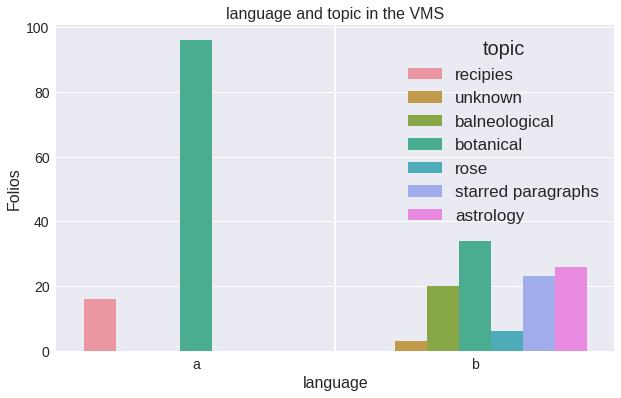

In [60]:
# general bar plot maker
# primary_group determines the categories for the main bar graph
# secondary_group determines the categories for the colored sub-bars
def plot_bar(primary_group, secondary_group, df_in=vms_df):
    df_in = df_in[df_in.folio != 'f57v'] # drop f57v because it has no useful info
    # generate the histogram df
    if primary_group not in df_in.columns or secondary_group not in df_in.columns:
        print("Error: Invalid groups")
        return -1
    primary_categories = list(set(df_in[primary_group].values))
    secondary_categories = list(set(df_in[secondary_group].values))
    print(primary_categories)
    print(secondary_categories)
    ax1 = list(np.sort(primary_categories*len(secondary_categories)))
    ax2 = secondary_categories*len(primary_categories)
    df = pd.DataFrame()
    df['ax1'] = ax1
    df['ax2'] = ax2
    counts = []
    for row in df.iterrows():
        selected = df_in[(df_in[primary_group] == row[1]['ax1']) & (df_in[secondary_group] == row[1]['ax2'])]
        counts.append(len(selected[primary_group].values))
    df['counts'] = counts
    
    fontsize = 16
    
    # start from a seaborn bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="ax1", hue="ax2", y="counts", data=df)
    ax = plt.gca()
    
    # add vertical lines between bar groups
    x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
    x_start = ax.get_xlim()[0]
    for i in range(len(primary_categories)-1):
        ax.axvline((x_range*(i+1))/(len(primary_categories)) + x_start, c='w')
    
    # format the labels
    ax.set_xlabel(primary_group, fontsize=fontsize)
    ax.set_ylabel('Folios', fontsize=fontsize)
    ax.set_title(primary_group+" and "+secondary_group+" in the VMS", fontsize=fontsize)
    ax.legend(fontsize=fontsize+1).set_title(secondary_group)
    for tick in ax.get_xticklabels(): tick.set_fontsize(fontsize-2)
    for tick in ax.get_yticklabels(): tick.set_fontsize(fontsize-2)
    print(ax.get_title())
    plt.savefig("./out/histograms/"+ax.get_title()+".png")
    plt.show()
    
plot_bar('topic_nmf', 'language')
plot_bar('topic_nmf', 'topic')
plot_bar('topic_nmf', 'hand')
plot_bar('topic', 'language')
plot_bar('language', 'topic')


[0, 1, 2, 3]
['b', 'a']
topic_nmf and language in the VMS


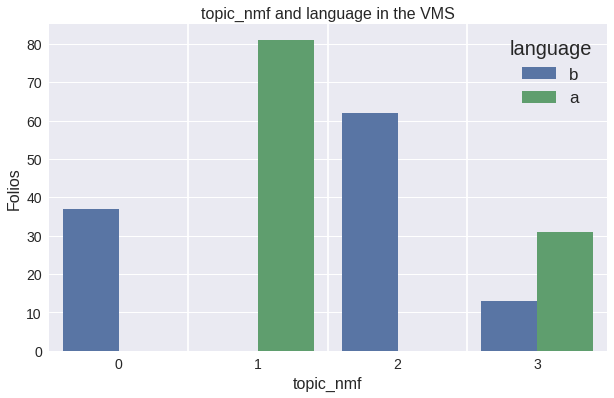

[0, 1, 2, 3]
['recipies', 'unknown', 'balneological', 'botanical', 'rose', 'starred paragraphs', 'astrology']
topic_nmf and topic in the VMS


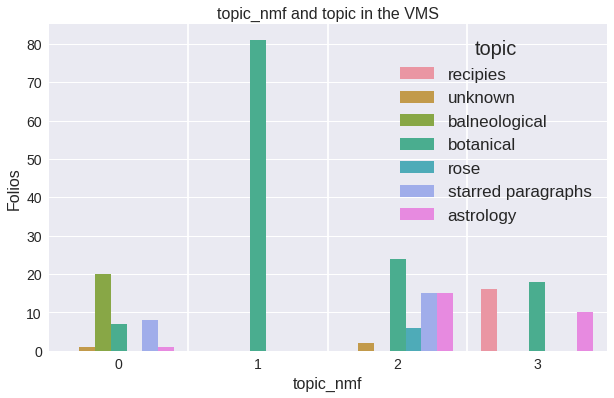

[0, 1, 2, 3]
[1, 2, 3, 4]
topic_nmf and hand in the VMS


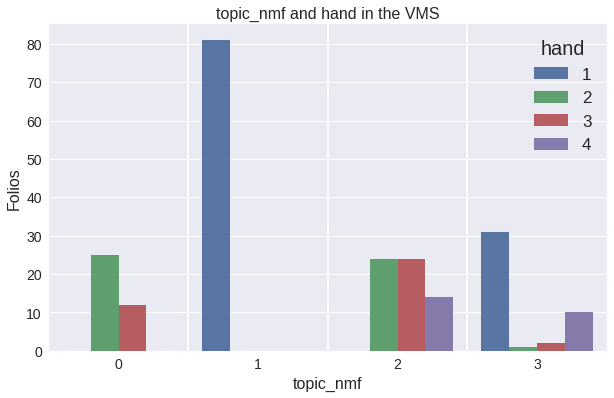

['b', 'a']
[0, 1, 2, 3]
language and topic_nmf in the VMS


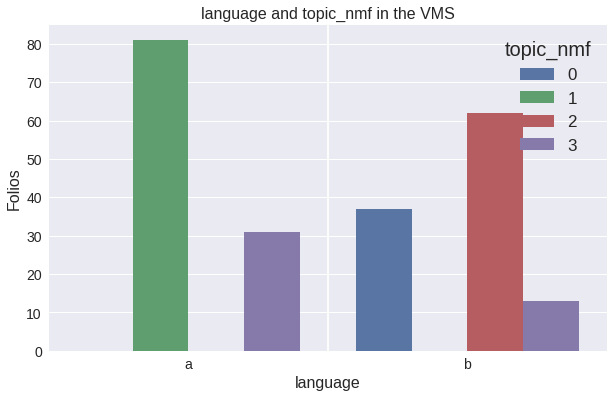

['recipies', 'unknown', 'balneological', 'botanical', 'rose', 'starred paragraphs', 'astrology']
[0, 1, 2, 3]
topic and topic_nmf in the VMS


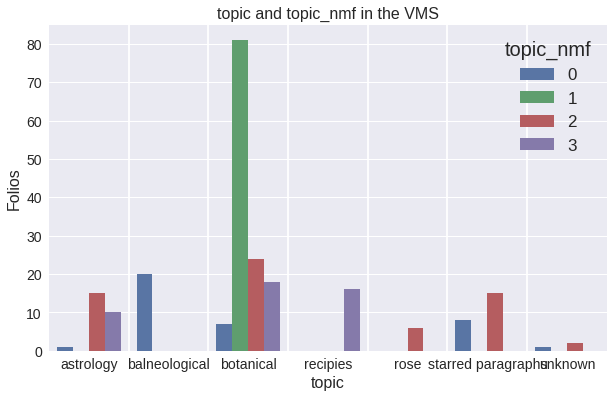

[1, 2, 3, 4]
[0, 1, 2, 3]
hand and topic_nmf in the VMS


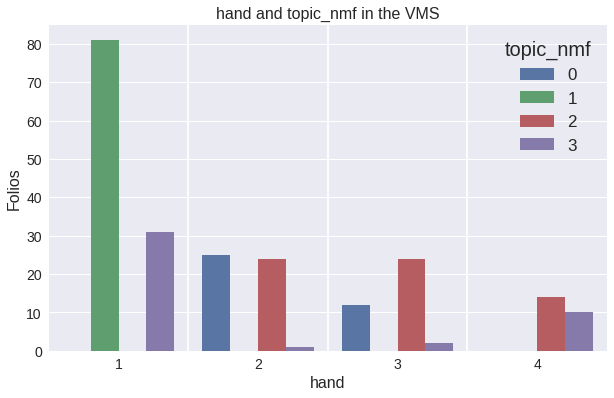

[0, 1, 2, 3]
['b', 'a']
topic_lsa and language in the VMS


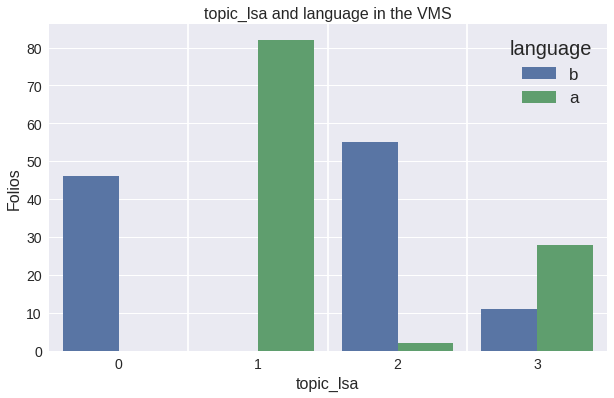

[0, 1, 2, 3]
['recipies', 'unknown', 'balneological', 'botanical', 'rose', 'starred paragraphs', 'astrology']
topic_lsa and topic in the VMS


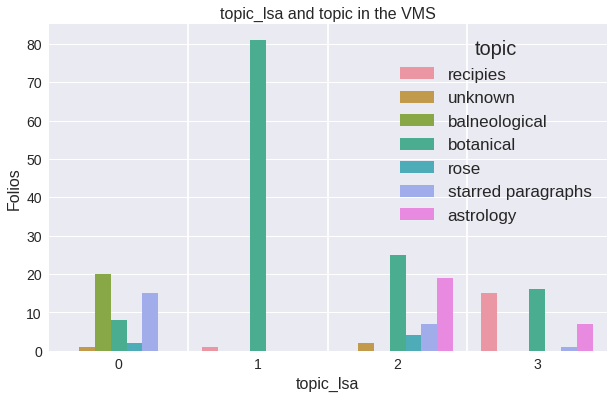

[0, 1, 2, 3]
[1, 2, 3, 4]
topic_lsa and hand in the VMS


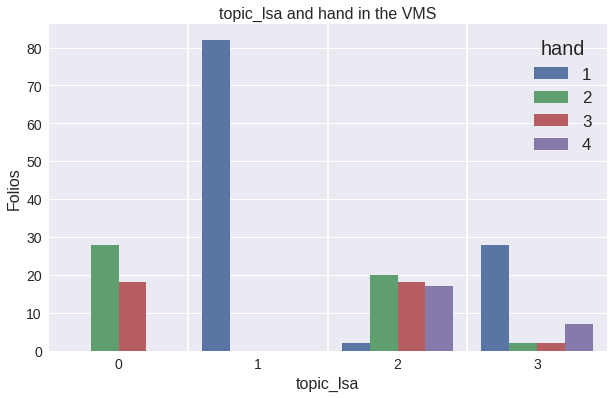

['b', 'a']
[0, 1, 2, 3]
language and topic_lsa in the VMS


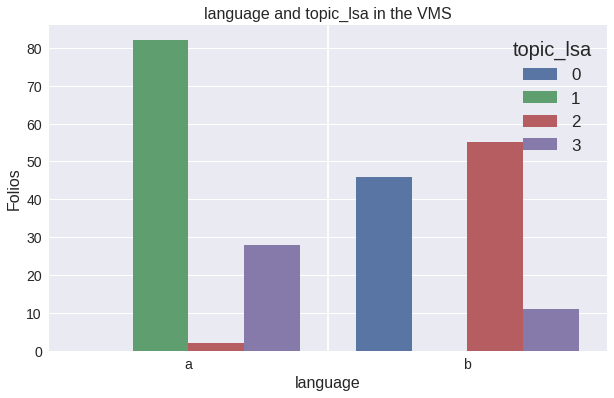

['recipies', 'unknown', 'balneological', 'botanical', 'rose', 'starred paragraphs', 'astrology']
[0, 1, 2, 3]
topic and topic_lsa in the VMS


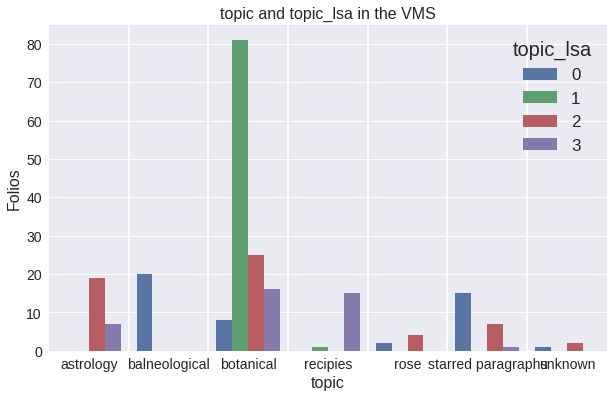

[1, 2, 3, 4]
[0, 1, 2, 3]
hand and topic_lsa in the VMS


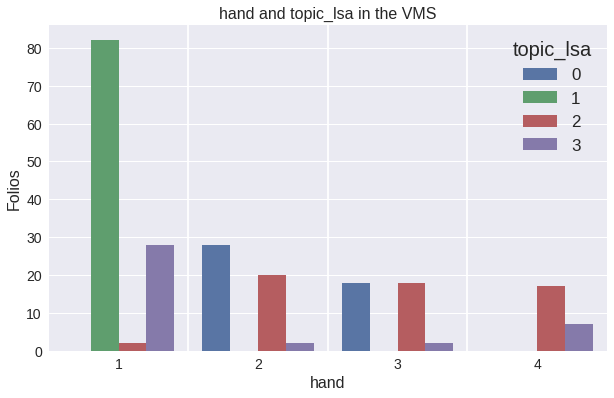

['recipies', 'unknown', 'balneological', 'botanical', 'rose', 'starred paragraphs', 'astrology']
['b', 'a']
topic and language in the VMS


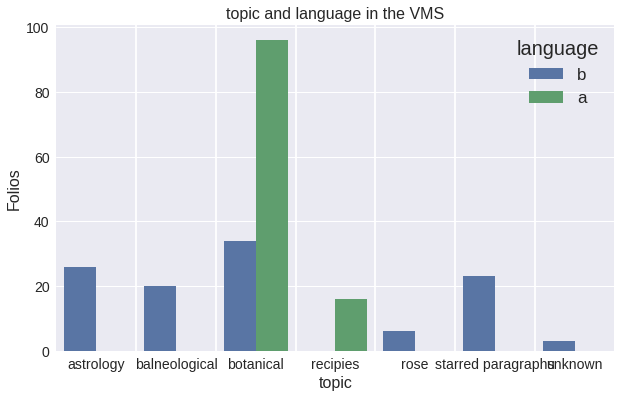

['b', 'a']
['recipies', 'unknown', 'balneological', 'botanical', 'rose', 'starred paragraphs', 'astrology']
language and topic in the VMS


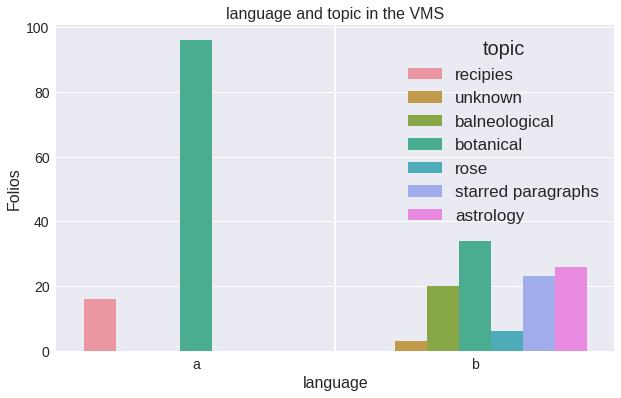

['recipies', 'unknown', 'balneological', 'botanical', 'rose', 'starred paragraphs', 'astrology']
[1, 2, 3, 4]
topic and hand in the VMS


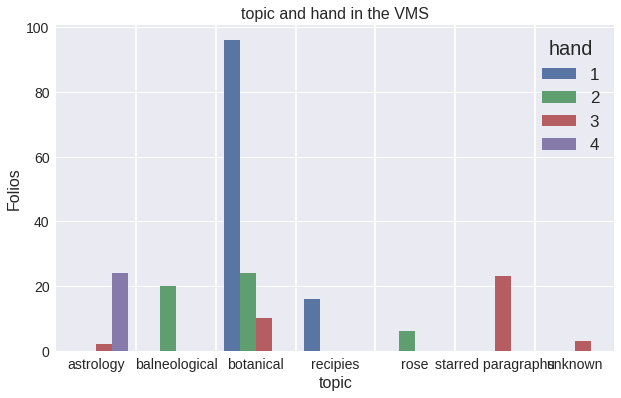

[1, 2, 3, 4]
['recipies', 'unknown', 'balneological', 'botanical', 'rose', 'starred paragraphs', 'astrology']
hand and topic in the VMS


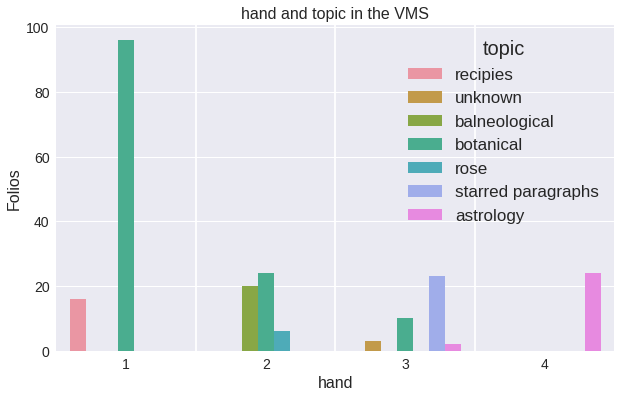

In [61]:
# make alllll the histograms
plot_bar('topic_nmf', 'language')
plot_bar('topic_nmf', 'topic')
plot_bar('topic_nmf', 'hand')
plot_bar('language', 'topic_nmf')
plot_bar('topic', 'topic_nmf')
plot_bar('hand', 'topic_nmf')

plot_bar('topic_lsa', 'language')
plot_bar('topic_lsa', 'topic')
plot_bar('topic_lsa', 'hand')
plot_bar('language', 'topic_lsa')
plot_bar('topic', 'topic_lsa')
plot_bar('hand', 'topic_lsa')

plot_bar('topic', 'language')
plot_bar('language', 'topic')

plot_bar('topic', 'hand')
plot_bar('hand', 'topic')